In [ ]:
from google.colab import files
uploaded = files.upload()

Saving DadosWine.xlsx to DadosWine.xlsx


+-------+----------------------+--------------------+--------------------+-----------------------+-----------------------+------------------------+
| Época | Acurácia Treinamento | Acurácia Validação |   Acurácia Teste   |    MSE Treinamento    |     MSE Validação     |       MSE Teste        |
+-------+----------------------+--------------------+--------------------+-----------------------+-----------------------+------------------------+
|   0   |      0.4921875       |       0.375        | 0.5555555555555556 |  0.22029605745677383  |  0.23755136838944232  |  0.21750144796692797   |
|  100  |      0.9765625       |        1.0         |        1.0         |  0.026194061881937302 |  0.027430966217775455 |  0.02340930189965426   |
|  200  |      0.9921875       |        1.0         |        1.0         |  0.009745676043957381 |  0.009062434253666343 |  0.007137377659298257  |
|  300  |         1.0          |        1.0         |        1.0         |  0.005737599327342385 |  0.0051115910

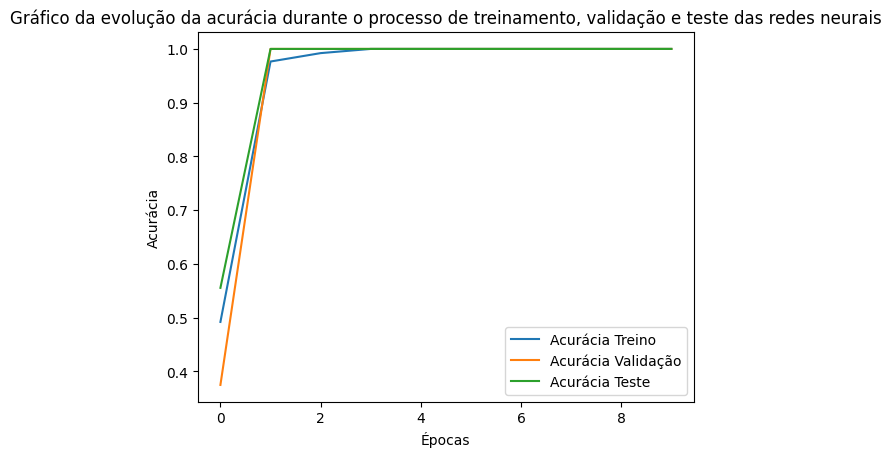

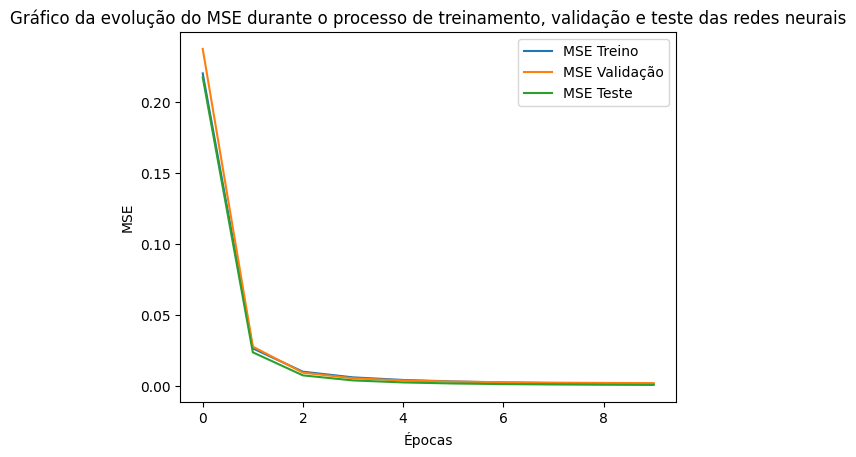

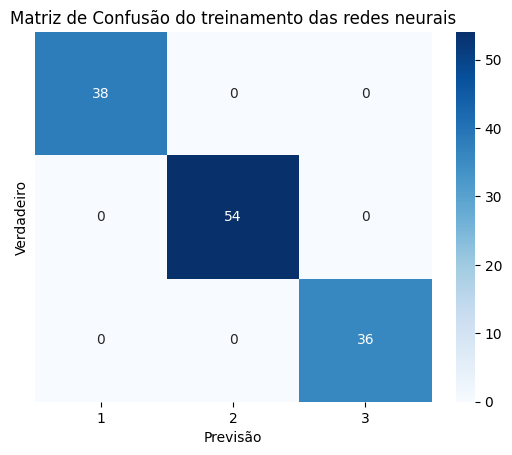

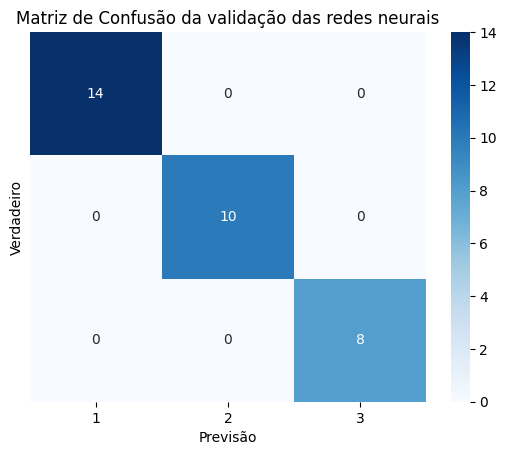

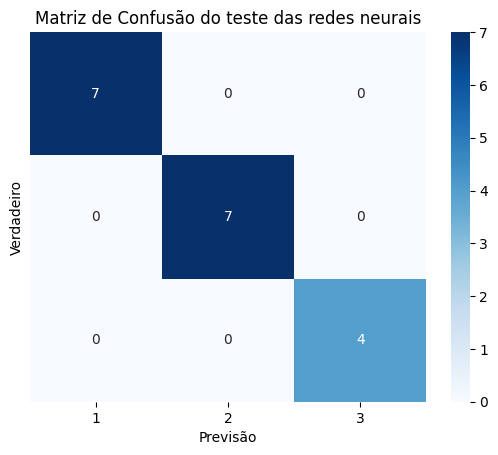

In [ ]:
import numpy as np
import pandas as pd
import io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from prettytable import PrettyTable
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer

def sigmoide(x):
  return 1 / (1 + np.exp(-x)) #Define a função sigmoide


def inicializar_pesos(input_tam, hidden_tam, output_tam):
  #np.random.seed(42) #Garantir que mesmo conjunto de números seja gerado

  w1 = np.random.randn(input_tam, hidden_tam) * np.sqrt(1 / input_tam) #Inicialização de Xavier para os pesos da camada de entrada
  #w1 = np.random.randn(input_tam, hidden_tam) * 1 #Inicialização aleatória simples
  b1 = np.zeros((1, hidden_tam)) #Inicializa o bias da camada de entrada com 0

  w2 = np.random.randn(hidden_tam, output_tam) * np.sqrt(1 / hidden_tam) #Inicialização de Xavier para os pesos da camada oculta
  #w2 = np.random.randn(hidden_tam, output_tam) * 1 #Inicialização aleatória simples
  b2 = np.zeros((1, output_tam)) #Inicializa o bias da camada oculta com 0

  return w1, b1, w2, b2


def forward_propagation (x, w1, b1, w2, b2):
  entrada_hidden = np.dot(x, w1) + b1 #Multiplica os dados de entrada pelos pesos da camada de entrada, somando, por fim, o bias - o resultado é a entrada da camada oculta
  saida_hidden = sigmoide(entrada_hidden) #Aplica a função sigmoide ao resultado, ou seja, na entrada da camada oculta

  entrada_output = np.dot(saida_hidden, w2) + b2 #Multiplica a saída da camada oculta com os pesos da camada oculta, somando, por fim, o bias - o resultado é a entrada da camada de saída
  saida_output = np.exp(entrada_output) / np.sum(np.exp(entrada_output), axis = 1, keepdims = True) #Converte o vetor de números reais entrada_output em um vetor de probabilidades - o resultado é a saída da rede
  
  return entrada_hidden, saida_hidden, saida_output


def backpropagation(x, y, saida_hidden, saida_output, w1, b1, w2, b2, taxa_aprendizado):
  delta_output = saida_output #Saída da rede neural
  delta_output[range(len(x)), y] -= 1 #Calcula a diferença entre saida_output (saída real) de y (saída esperada)
  delta_output /= len(x) #Normaliza delta

  delta_hidden = np.dot(delta_output, w2.T) * (saida_hidden *(1 - saida_hidden)) #Calcula o delta da camada oculta
  
  w2 -= taxa_aprendizado * np.dot(saida_hidden.T, delta_output) #Atualiza o peso
  b2 -= taxa_aprendizado * np.sum(delta_output, axis = 0, keepdims = True) #Atualiza o bias

  w1 -= taxa_aprendizado * np.dot(x.T, delta_hidden) #Atualiza o peso
  b1 -= taxa_aprendizado * np.sum(delta_hidden, axis = 0, keepdims = True) #Atualiza o bias

  return w1, b1, w2, b2


def erro_medio_quad (x, y, w1, b1, w2, b2):
  lb = LabelBinarizer() #Transforma uma variável de categorização em uma matriz binária
  y_one_hot = lb.fit_transform(y) #Armazena a transformação na variável

  entrada_hidden, saida_hidden, saida_output = forward_propagation(x, w1, b1, w2, b2) #Ativa a função foward_propagation para ter acesso a saída da rede, podendo, depois, calcular o MSE

  mse = np.mean((y_one_hot - saida_output)**2) #Calcula o MSE

  return mse


def previsao(x, w1, b1, w2, b2):
  entrada_hidden, saida_hidden, saida_output = forward_propagation(x, w1, b1, w2, b2)
  
  return np.argmax(saida_output, axis=1) #Encontra o índice do maior valor em cada saída de saida_output, correspondendo a previsão de saída associada a cada entrada


#LEITURA DOS DADOS
df = pd.read_excel(io.BytesIO(uploaded["DadosWine.xlsx"])) #Leitura do arquivo excel

x = df[["Álcool", "Ácido málico", "Cinzas", "Alcalinidade das cinzas", "Magnésio", "Fenóis totais", "Flavonoides", "Fenóis não flavonoides", "Proantocianidinas", "Intensidade de cor", "Matiz", "OD280/OD315", "Prolina"]].values #Armazena as features a serem avaliadas
y = df["ID Tipo"].values #Armazena as saídas esperadas


#NORMALIZAÇÃO DOS DADOS
x = (x - np.mean(x, axis = 0)) / np.std(x, axis = 0) #Normaliza os dados (zscore)


#SEPARAÇÃO DOS DADOS DE TREINAMENTO, VALIDAÇÃO E TESTE
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size = 0.10, random_state = 42) #10% dos dados serão usados para teste
x_treino, x_valid, y_treino, y_valid = train_test_split(x_treino, y_treino, test_size = 0.2, random_state = 42) #10% dos dados de treinamento serão usados para validação


#DEFINIÇÕES DA REDE NEURAL
input_tam = x_treino.shape[1] #Quantidade de neurônios da camada de entrada
hidden_tam = 5 #Quantidade de neurônios da camada oculta
output_tam = 3 #Quantidade de neurônios da camada de saída
taxa_aprendizado = 0.2 #Taxa de aprendizagem
qtd_epoca = 1000 #Número de iterações

  
#TREINAMENTO, VALIDAÇÃO E TESTE
w1, b1, w2, b2 = inicializar_pesos(input_tam, hidden_tam, output_tam) #Inicializa os pesos

vetor_acuracia_treino = [] #Inicializa vetor de acurácia do treinamento para plotar gráfico
vetor_acuracia_valid = [] #Inicializa vetor de acurácia da validação para plotar gráfico
vetor_acuracia_teste = [] #Inicializa vetor de acurácia do teste para plotar gráfico

vetor_erro_treino = [] #Inicializa vetor de MSE do treinamento para plotar gráfico
vetor_erro_valid = [] #Inicializa vetor de MSE da validação para plotar gráfico
vetor_erro_teste = [] #Inicializa vetor de MSE do teste para plotar gráfico

tabela = PrettyTable() #Cria a tabela
tabela.field_names = ["Época", "Acurácia Treinamento", "Acurácia Validação", "Acurácia Teste", "MSE Treinamento", "MSE Validação", "MSE Teste"] #Cria o label da tabela

for epoca in range(qtd_epoca):
  entrada_hidden, saida_hidden, saida_output = forward_propagation (x_treino, w1, b1, w2, b2)
  w1, b1, w2, b2 = backpropagation(x_treino, y_treino, saida_hidden, saida_output, w1, b1, w2, b2, taxa_aprendizado)

  if epoca % 100 == 0: #Se epoca for múltiplo de 100
    previsao_treino = previsao(x_treino, w1, b1, w2, b2) #Calcule a previsão do treinamento
    acuracia_treino = np.mean(previsao_treino == y_treino) #Calcule a acurácia do treinamento
    mse_treino = erro_medio_quad(x_treino, y_treino, w1, b1, w2, b2) #Calcule o MSE do treinamento
    
    vetor_acuracia_treino.append(acuracia_treino) #Vetor de acurácia do treinamento
    vetor_erro_treino.append(mse_treino) #Vetor de MSE do treinamento


    previsao_valid = previsao(x_valid, w1, b1, w2, b2) #Calcule a previsão da validação
    acuracia_valid = np.mean(previsao_valid == y_valid) #Calcule a acurácia da validação
    mse_valid = erro_medio_quad(x_valid, y_valid, w1, b1, w2, b2) #Calcule o MSE da validação
    
    vetor_acuracia_valid.append(acuracia_valid) #Vetor de acurácia da validação
    vetor_erro_valid.append(mse_valid) #Vetor de MSE da validação


    previsao_teste = previsao(x_teste, w1, b1, w2, b2) #Calcule a previsão da validação
    acuracia_teste = np.mean(previsao_teste == y_teste) #Calcule a acurácia da validação
    mse_teste = erro_medio_quad(x_teste, y_teste, w1, b1, w2, b2) #Calcule o MSE da validação
    
    vetor_acuracia_teste.append(acuracia_teste) #Vetor de acurácia da validação
    vetor_erro_teste.append(mse_teste) #Vetor de MSE da validação

    tabela.add_row([epoca, acuracia_treino, acuracia_valid, acuracia_teste, mse_treino, mse_valid, mse_teste]) #Imprime os dados em uma tabela
print(tabela) #Imprime os dados em uma tabela

#MATRIZ DE CONFUSÃO
matriz_treino = confusion_matrix(previsao_treino, y_treino)
print("\nMatriz de Confusão do Treinamento:")
print(matriz_treino)

matriz_valid = confusion_matrix(previsao_valid, y_valid)
print("\nMatriz de Confusão da Validação:")
print(matriz_valid)

matriz_teste = confusion_matrix(previsao_teste, y_teste)
print("\nMatriz de Confusão do Teste:")
print(matriz_teste)


#GRÁFICOS
plt.plot(range(len(vetor_acuracia_treino)), vetor_acuracia_treino, label = "Acurácia Treino")
plt.plot(range(len(vetor_acuracia_valid)), vetor_acuracia_valid, label = "Acurácia Validação")
plt.plot(range(len(vetor_acuracia_teste)), vetor_acuracia_teste, label = "Acurácia Teste")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.title("Gráfico da evolução da acurácia durante o processo de treinamento, validação e teste das redes neurais")
plt.legend()
plt.show()

plt.plot(range(len(vetor_erro_treino)), vetor_erro_treino, label = "MSE Treino")
plt.plot(range(len(vetor_erro_valid)), vetor_erro_valid, label = "MSE Validação")
plt.plot(range(len(vetor_erro_teste)), vetor_erro_teste, label = "MSE Teste")
plt.xlabel("Épocas")
plt.ylabel("MSE")
plt.title("Gráfico da evolução do MSE durante o processo de treinamento, validação e teste das redes neurais")
plt.legend()
plt.show()

sns.heatmap(matriz_treino, annot=True, cmap='Blues', fmt='g', xticklabels="123", yticklabels="")
plt.xlabel('Previsão')
plt.title("Matriz de Confusão do treinamento das redes neurais")
plt.ylabel('Verdadeiro')
plt.show()

sns.heatmap(matriz_valid, annot=True, cmap='Blues', fmt='g', xticklabels="123", yticklabels="")
plt.xlabel('Previsão')
plt.title("Matriz de Confusão da validação das redes neurais")
plt.ylabel('Verdadeiro')
plt.show()

sns.heatmap(matriz_teste, annot=True, cmap='Blues', fmt='g', xticklabels="123", yticklabels="")
plt.xlabel('Previsão')
plt.title("Matriz de Confusão do teste das redes neurais")
plt.ylabel('Verdadeiro')
plt.show()